<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-autogluon?scriptVersionId=235081162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2 autogluon.tabular==1.2 ray==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 3.7 MB/s eta 0:00:00


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
import joblib
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"
    
    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 5

# Loading data and predefining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

In [5]:
kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

In [6]:
original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

# Fitting the predictor

In [7]:
predictor = TabularPredictor(
    path="/MrAutogluonModels",
    problem_type="regression",
    eval_metric="rmse",
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [8]:
predictor.fit_pseudolabel(
    pseudo_data=original,
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN", "NN_TORCH", "XGB"]
)

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.13 GB / 31.35 GB (96.1%)
Disk Space Avail:   1784.43 GB / 8062.39 GB (22.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the

(_ray_fit pid=422) [1000]	valid_set's rmse: 13.0351
(_ray_fit pid=422) [2000]	valid_set's rmse: 13.0216 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=420) [3000]	valid_set's rmse: 13.0287 [repeated 4x across cluster]
(_ray_fit pid=421) [4000]	valid_set's rmse: 13.0437 [repeated 3x across cluster]
(_ray_fit pid=419) [4000]	valid_set's rmse: 12.9378
(_ray_fit pid=527) [1000]	valid_set's rmse: 13.0041
(_ray_fit pid=527) [2000]	valid_set's rmse: 12.9887


(_dystack pid=153) 	-13.0098	 = Validation score   (-root_mean_squared_error)
(_dystack pid=153) 	342.66s	 = Training   runtime
(_dystack pid=153) 	227.67s	 = Validation runtime
(_dystack pid=153) Fitting model: LightGBM_BAG_L1 ... Training model for up to 2613.25s of the 4111.05s of remaining time.
(_dystack pid=153) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.66%)


(_ray_fit pid=645) [1000]	valid_set's rmse: 13.0136
(_ray_fit pid=645) [2000]	valid_set's rmse: 12.9954 [repeated 4x across cluster]
(_ray_fit pid=645) [3000]	valid_set's rmse: 12.9911 [repeated 4x across cluster]
(_ray_fit pid=757) [1000]	valid_set's rmse: 12.9632 [repeated 2x across cluster]
(_ray_fit pid=644) [4000]	valid_set's rmse: 12.9062
(_ray_fit pid=757) [2000]	valid_set's rmse: 12.9534
(_ray_fit pid=757) [3000]	valid_set's rmse: 12.9572


(_dystack pid=153) 	-12.9755	 = Validation score   (-root_mean_squared_error)
(_dystack pid=153) 	286.76s	 = Training   runtime
(_dystack pid=153) 	152.47s	 = Validation runtime
(_dystack pid=153) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 2292.80s of the 3790.60s of remaining time.
(_dystack pid=153) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=153) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.57%)
(_ray_fit pid=874) 	Warning: Reducing model 'n_estimators' from 300 -> 159 due to low time. Expected time usage reduced from 1727.4s -> 916.9s...
(_ray_fit pid=1046) 	Warning: Reducing model 'n_estimators' from 300 -> 223 due to low time. Expected time usage reduced from 1231.5s -> 916.6s... [repeated 4x across cluster]
(_dystack pid=153) 	-12.8599	 = Validation score   (-root_mean_squared_error)
(_dystack pid=153) 	1221.0s	 = Training   runtime
(_dystack 

In [9]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3_PSEUDO,-12.650280,root_mean_squared_error,2504.176476,29221.658218,0.013781,2.916178,3,True,31
1,CatBoost_BAG_L2_PSEUDO,-12.663282,root_mean_squared_error,1476.179674,13830.359669,4.277115,2038.038450,2,True,27
2,LightGBM_BAG_L2_PSEUDO,-12.678527,root_mean_squared_error,1480.749547,11846.052188,8.846988,53.730969,2,True,25
3,NeuralNetFastAI_BAG_L2_PSEUDO,-12.687793,root_mean_squared_error,1487.161459,11879.510015,15.258901,87.188796,2,True,29
4,WeightedEnsemble_L3,-12.691091,root_mean_squared_error,986.855967,12873.619414,0.024932,1.528862,3,True,15
5,ExtraTreesMSE_BAG_L2_PSEUDO,-12.704224,root_mean_squared_error,1483.052856,12160.881000,11.150297,368.559781,2,True,28
6,CatBoost_BAG_L2,-12.705718,root_mean_squared_error,946.092256,9850.325746,1.741499,1157.062048,2,True,12
7,LightGBM_BAG_L2,-12.710163,root_mean_squared_error,956.469441,8749.168277,12.118685,55.904580,2,True,10
8,NeuralNetFastAI_BAG_L2,-12.710788,root_mean_squared_error,959.784391,8888.613795,15.433635,195.350097,2,True,13
9,LightGBMXT_BAG_L2_PSEUDO,-12.722460,root_mean_squared_error,1502.767082,11915.924723,30.864524,123.603504,2,True,24


# Visualizing the ensemble weights

In [10]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

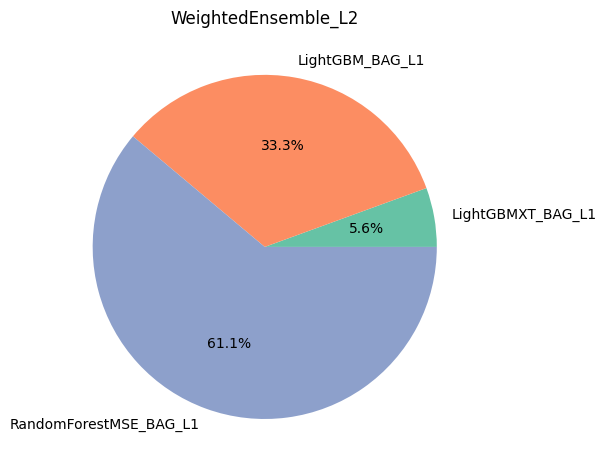

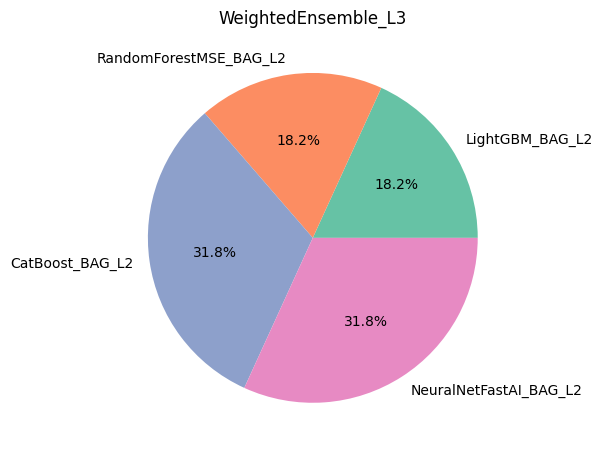

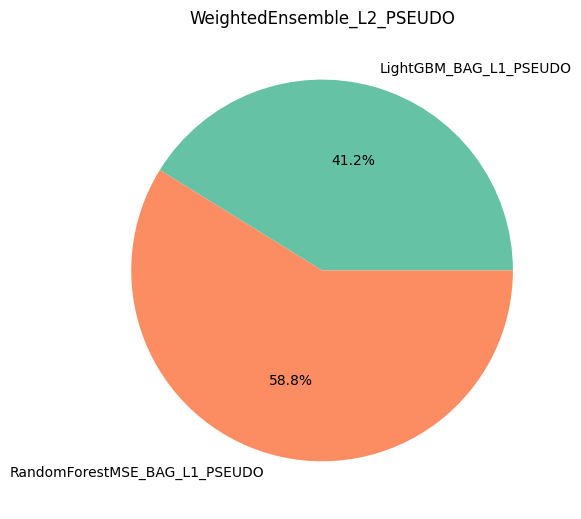

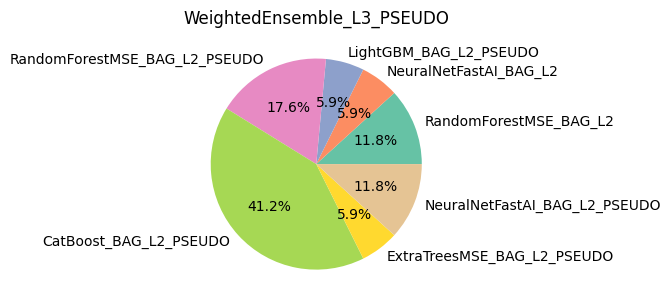

In [11]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [12]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = "oof_preds" if type == "oof" else "test_preds"
    base_path = "." if is_ensemble else base_path
    joblib.dump(preds, f"{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl")

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_preds
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_preds", exist_ok=True)
os.makedirs("test_preds", exist_ok=True)

In [13]:
oof_preds = {}
test_preds = {}

In [14]:
best_model = predictor.model_best
_test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = _test_preds[model].values
    
    cv_score = root_mean_squared_error(train[CFG.target], model_oof_preds)
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, "oof", False)
        save_preds(model_test_preds, cv_score, model, "test", False)
    else:
        save_preds(model_oof_preds, cv_score, model, "oof", True)
        save_preds(model_test_preds, cv_score, model, "test", True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

# Visualizing the results

In [15]:
scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=False).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = root_mean_squared_error(train.loc[val_index, CFG.target], oof_preds[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

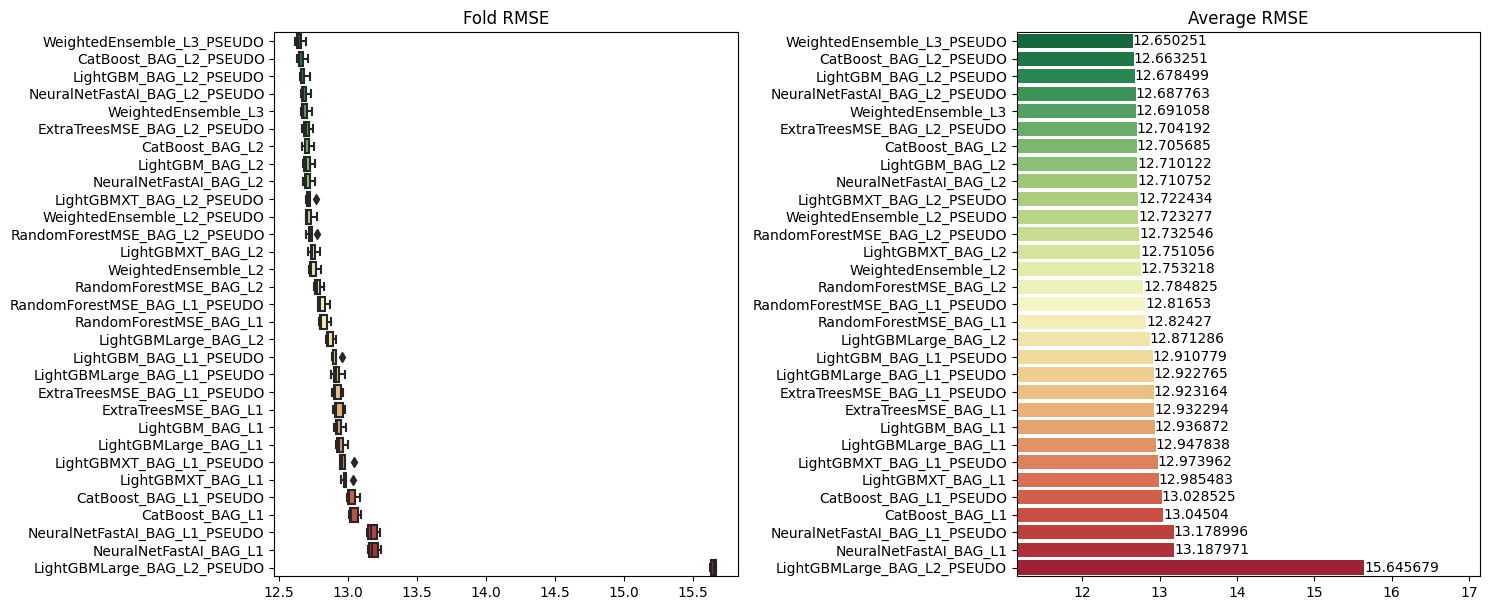

In [16]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold RMSE")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average RMSE")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()